In [11]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score
import torch
from torch.optim import Adam

In [12]:

class MNISTSubset:
    def __init__(self, num_samples, num_classes):
        self.num_samples = num_samples
        self.num_classes = num_classes

    def load_data(self):
        # 加载原始 MNIST 数据集
        train_images = idx2numpy.convert_from_file(r"..\train-images.idx3-ubyte")
        train_labels = idx2numpy.convert_from_file(r"..\train-labels.idx1-ubyte")
        test_images = idx2numpy.convert_from_file(r"..\t10k-images.idx3-ubyte")
        test_labels = idx2numpy.convert_from_file(r"..\t10k-labels.idx1-ubyte")

        # 数据预处理
        train_images = train_images.reshape((train_images.shape[0], -1)).astype('float32') / 255
        test_images = test_images.reshape((test_images.shape[0], -1)).astype('float32') / 255

        # 计算原始数据集中训练集和测试集的比例
        total_train = train_images.shape[0]
        total_test = test_images.shape[0]
        train_test_ratio = total_train / total_test

        # 提取所需类别的样本
        train_data, test_data = self.extract_subset(train_images, train_labels, test_images, test_labels, train_test_ratio)

        return train_data, test_data

    def extract_subset(self, train_images, train_labels, test_images, test_labels, train_test_ratio):
        # 计算训练集和测试集的样本数量
        total_samples = self.num_samples
        train_samples = int(total_samples * train_test_ratio / (1 + train_test_ratio))
        test_samples = total_samples - train_samples

        # 按类别从训练集和测试集中随机抽取样本
        train_subset_indices = []
        test_subset_indices = []

        for i in range(self.num_classes):
            train_indices_i = np.where(train_labels == i)[0]
            test_indices_i = np.where(test_labels == i)[0]

            train_subset_indices_i = np.random.choice(train_indices_i, min(len(train_indices_i), train_samples // self.num_classes), replace=False)
            test_subset_indices_i = np.random.choice(test_indices_i, min(len(test_indices_i), test_samples // self.num_classes), replace=False)

            train_subset_indices.extend(train_subset_indices_i)
            test_subset_indices.extend(test_subset_indices_i)

        # 提取子集
        train_images_subset = train_images[train_subset_indices]
        train_labels_subset = train_labels[train_subset_indices]
        test_images_subset = test_images[test_subset_indices]
        test_labels_subset = test_labels[test_subset_indices]

        # one-hot 编码
        train_labels_subset = self.one_hot_encode(train_labels_subset)
        test_labels_subset = self.one_hot_encode(test_labels_subset)

        return (train_images_subset, train_labels_subset), (test_images_subset, test_labels_subset)

    def one_hot_encode(self, labels):
        # 将类别标签转换为 one-hot 编码格式
        one_hot_labels = np.zeros((labels.shape[0], self.num_classes))
        one_hot_labels[np.arange(labels.shape[0]), labels] = 1
        return one_hot_labels

num_classes = 8
mnist_subset = MNISTSubset(5000, num_classes)  # 总共 3000 个样本, 8 个类别
train_data, test_data = mnist_subset.load_data()

train_data_encode = (torch.FloatTensor(train_data[0]).requires_grad_(True), torch.LongTensor(train_data[1]))
test_data_encode = (torch.FloatTensor(test_data[0]).requires_grad_(True), torch.LongTensor(test_data[1]))

train_images, train_labels = train_data_encode
test_images, test_labels = test_data_encode

print(train_images.shape)
print(train_labels.shape)


torch.Size([4280, 784])
torch.Size([4280, 8])


In [13]:
def fresult(y_pred, y_label):
    samples = y_pred.shape[0]
    result = torch.zeros(samples)
    for i in range(samples):
        if y_pred[i] != y_label[i]:
            result[i] = 1
    return result


def fprediction(nets, alphas, datas, n_classes):
    samples, dims = datas.shape
    preds = torch.zeros(samples, n_classes)
    for (i, net) in enumerate(nets):
        pred_i = net(datas)
        # print(pred_i.shape)
        # print(alphas[i])
        preds += pred_i * alphas[i]
    # print(preds)
    return torch.argmax(torch.softmax(preds, dim=1), dim=1)

In [14]:
sample = train_images.shape[0]
sample_weights = torch.ones(sample) / sample


各分类器权重[1.43, -0.73, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0]


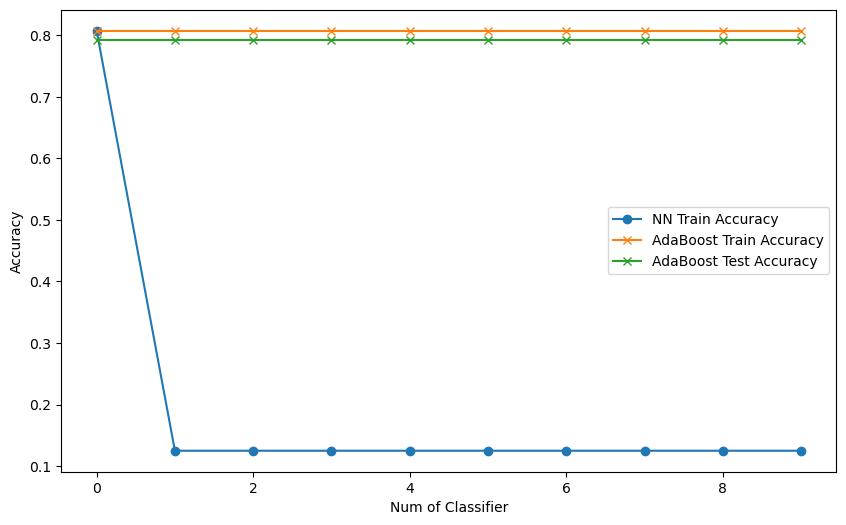

In [15]:

nets = []
alphas = []

num_classifer = 10
main_train_acc = []
adaboost_train_acc = []
adaboost_test_acc = []

for i in range(num_classifer):
    net = torch.nn.Sequential(
        torch.nn.Linear(784, 12),  # 第一个隐藏层，784个输入特征，128个输出特征
        torch.nn.Sigmoid(),
        torch.nn.Linear(12,8),
        torch.nn.Softmax(dim=1)     # Softmax激活函数应用于输出层
    )
    optimizer = Adam(net.parameters(), lr=0.1)
    loss_func = torch.nn.CrossEntropyLoss(reduction="none")
    out = net(train_images)

    for t in range(10):
        out = net(train_images) 
        train_labels_indices = torch.argmax(train_labels, dim=1)
        loss = loss_func(out, train_labels_indices)
        loss = (sample_weights * loss).sum()
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

    y_pred = net(train_images)
    y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=-1)
    train_acc = accuracy_score(torch.argmax(train_labels, dim=1).detach().numpy(), y_pred.detach().numpy())

    # print("分类器训练集准确率: ", train_acc)
    main_train_acc.append(train_acc)

    result = fresult(torch.argmax(train_labels, dim=1).detach().numpy(), y_pred.numpy())
    ferror = torch.sum(result * sample_weights)
    # print("错误率 = %f" % ferror)


    if ferror == 0:
        alpha = 10
        alphas.append(alpha)
        # ansatz_params.append(ccq.get_ansatz_param())
        break
    else:
        if ferror < 1:
            alpha = math.log((1 - ferror) / ferror)
        else:
            alpha = 0

    sample_weights = sample_weights * torch.exp(alpha * result)
    sample_weights /= torch.sum(sample_weights)
    nets.append(net)
    alphas.append(alpha)

    y_pred = fprediction(nets, alphas, train_images, num_classes)
    y_test_pre = fprediction(nets, alphas, test_images, num_classes)

    # print("adaboost训练准确率: ", accuracy_score(torch.argmax(train_labels, dim=1).detach().numpy(), y_pred.detach().numpy()))
    adaboost_train_acc.append(accuracy_score(torch.argmax(train_labels, dim=1).detach().numpy(), y_pred.detach().numpy()))

    # print("adaboost测试准确率: ", accuracy_score(torch.argmax(test_labels, dim=1).detach().numpy(), y_test_pre.detach().numpy()))
    adaboost_test_acc.append(accuracy_score(torch.argmax(test_labels, dim=1).detach().numpy(), y_test_pre.detach().numpy()))

alphas = [round(alpha, 2) for alpha in alphas]
print(f'各分类器权重{alphas}')

plt.figure(figsize=(10, 6))

# 绘制主训练准确率
plt.plot(range(num_classifer), main_train_acc, label='NN Train Accuracy', marker='o')

# 绘制 AdaBoost 训练准确率
plt.plot(range(num_classifer), adaboost_train_acc, label='AdaBoost Train Accuracy', marker='x')
plt.plot(range(num_classifer), adaboost_test_acc, label='AdaBoost Test Accuracy', marker='x')
# 添加图例
plt.legend()

# 添加标题和轴标签
# plt.title('Training Accuracy vs L_c')
plt.xlabel('Num of Classifier')
plt.ylabel('Accuracy')

# 显示图表
plt.show()